In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from gorgo import observe
from gorgo.core import Bernoulli
from gorgo.inference import SamplePrior, Enumeration, LikelihoodWeighting, MetropolisHastings

## Geometric Distribution

In [2]:
def geometric(p, i=0):
    x = Bernoulli(p).sample(name=f"x_{i}")
    if x == 0:
        return 0
    return 1 + geometric(p, i + 1)

In [3]:
p = .8
enum_dist = Enumeration(geometric, max_executions=50).run(p)
lw_dist = LikelihoodWeighting(geometric, samples=2000).run(p)
prior_dist = SamplePrior(geometric, samples=2000).run(p)
mh_dist = MetropolisHastings(geometric, samples=2000, burn_in=100, thinning=50).run(p)

<AxesSubplot:xlabel='k', ylabel='p'>

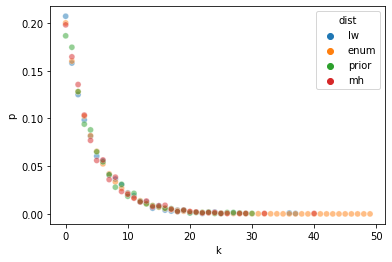

In [4]:
df = pd.DataFrame(
    [dict(k=k, p=v, dist='lw') for k, v in lw_dist.items()] + 
    [dict(k=k, p=v, dist='enum') for k, v in enum_dist.items()] + 
    [dict(k=k, p=v, dist='prior') for k, v in prior_dist.items()] + 
    [dict(k=k, p=v, dist='mh') for k, v in mh_dist.items()]
)
sns.scatterplot(
    data=df,
    x='k',
    y='p',
    hue='dist',
    alpha=.5
)

In [5]:
for dist, dist_df in df.groupby('dist'):
    print(f'exp under {dist}: {sum(dist_df["k"]*dist_df["p"]):.2f}')

exp under enum: 4.00
exp under lw: 3.99
exp under mh: 4.01
exp under prior: 4.05


## Hidden Markov Model

In [6]:
def hmm(observations, last_state=None, stay_prob=.9, coherence=.8, horizon=10):
    if horizon == 0 or len(observations) == 0:
        return ()
    if last_state is None:
        last_state = int(Bernoulli(.5).sample())
    stay = Bernoulli(stay_prob).sample()
    cur_state = last_state if stay else {0: 1, 1: 0}[last_state]
    observe(Bernoulli(coherence), cur_state == observations[0])
    future_states = hmm(observations[1:], last_state=cur_state, stay_prob=stay_prob, coherence=coherence, horizon=horizon - 1)
    return (cur_state,) + future_states

def calc_hmm_marginals(seq_dist):
    seqs, probs = zip(*seq_dist.items())
    marg = (np.array(seqs)*np.array(probs)[:, None]).sum(0)
    return tuple(marg)

In [7]:
obs_seq = (1, 1, 0, 1, 1, 0, 0, 0)
enum_hmm_marg = calc_hmm_marginals(Enumeration(hmm, max_executions=100).run(obs_seq))
lw_hmm_marg = calc_hmm_marginals(LikelihoodWeighting(hmm, samples=2000).run(obs_seq))
mh_hmm_marg = calc_hmm_marginals(MetropolisHastings(hmm, samples=2000, burn_in=100, thinning=20, seed=None).run(obs_seq))

<AxesSubplot:xlabel='t', ylabel='x'>

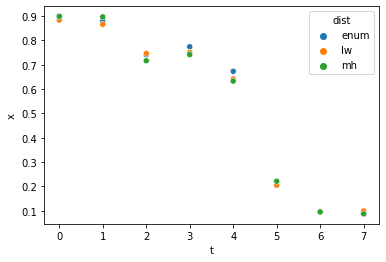

In [8]:
df = pd.DataFrame(
    [dict(t=t, x=x, dist="enum") for t, x in enumerate(enum_hmm_marg)] +
    [dict(t=t, x=x, dist="lw") for t, x in enumerate(lw_hmm_marg)] + 
    [dict(t=t, x=x, dist="mh") for t, x in enumerate(mh_hmm_marg)]
)
sns.scatterplot(
    data=df,
    x='t',
    y='x',
    hue='dist',
)
    